# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

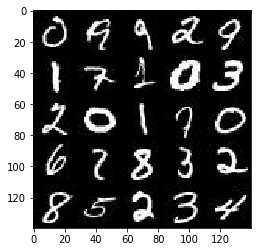

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

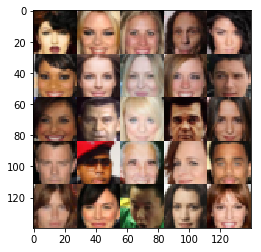

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        relu1 = tf.maximum(x1 * 0.1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        relu2 = tf.maximum(x2 * 0.1, x2)
        y2 = tf.layers.batch_normalization(x2, training=True)

        x3 = tf.layers.conv2d(y2, 256, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        relu3 = tf.maximum(x3 * 0.1, x3)
        y3 = tf.layers.batch_normalization(x3, training=True)

        flattened = tf.reshape(y3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1_reshape = tf.reshape(x1, (-1, 7, 7, 256))
        relu1 = tf.maximum(x1_reshape * 0.1, x1_reshape)
        x1_norm = tf.layers.batch_normalization(relu1, training=is_train)
        
        x2 = tf.layers.conv2d_transpose(x1_norm, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu2 = tf.maximum(x2 * 0.1, x2)
        x2_norm = tf.layers.batch_normalization(relu2, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2_norm, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu3 = tf.maximum(x3 * 0.1, x3)
        x3_norm = tf.layers.batch_normalization(relu3, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x3_norm, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real, d_real_logits = discriminator(input_real)
    d_fake, d_fake_logits = discriminator(g_model, reuse=True)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real) * (1 - 0.1)))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake)))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies([opt for opt in update_ops if opt.name.startswith('discriminator')]):
        d_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies([opt for opt in update_ops if opt.name.startswith('generator')]):
        g_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt_train, g_opt_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt_train, g_opt_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt_train, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt_train, feed_dict={input_z: batch_z})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 2.0730
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 3.0565
Epoch 1/2... Discriminator Loss: 0.3983... Generator Loss: 3.6363
Epoch 1/2... Discriminator Loss: 0.4263... Generator Loss: 3.4254
Epoch 1/2... Discriminator Loss: 0.4074... Generator Loss: 3.6925
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 3.6577
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 5.1161
Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 4.6906
Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 4.1599
Epoch 1/2... Discriminator Loss: 0.3868... Generator Loss: 4.0712


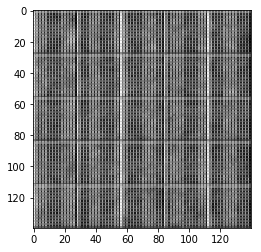

Epoch 1/2... Discriminator Loss: 0.3909... Generator Loss: 4.0827
Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 4.4535
Epoch 1/2... Discriminator Loss: 0.3488... Generator Loss: 4.5396
Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 4.1139
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 3.8034
Epoch 1/2... Discriminator Loss: 0.4455... Generator Loss: 5.0335
Epoch 1/2... Discriminator Loss: 0.3624... Generator Loss: 4.2129
Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 4.3655
Epoch 1/2... Discriminator Loss: 0.4434... Generator Loss: 3.9794
Epoch 1/2... Discriminator Loss: 0.3546... Generator Loss: 4.5792


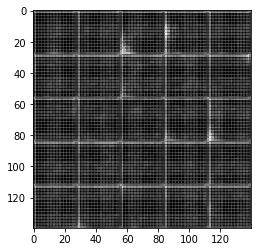

Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 4.1191
Epoch 1/2... Discriminator Loss: 0.3979... Generator Loss: 3.2812
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.2580
Epoch 1/2... Discriminator Loss: 0.5142... Generator Loss: 2.5158
Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 6.9583
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 0.5556... Generator Loss: 2.2623
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 2.3380
Epoch 1/2... Discriminator Loss: 0.8285... Generator Loss: 1.1627


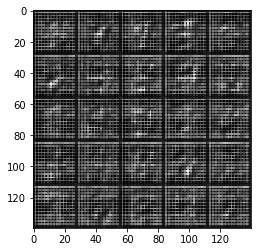

Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.5658
Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 1.1658
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 2.0065
Epoch 1/2... Discriminator Loss: 0.7009... Generator Loss: 1.9895
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.5505
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 1.8801
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 1.9685
Epoch 1/2... Discriminator Loss: 0.9411... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 0.8946


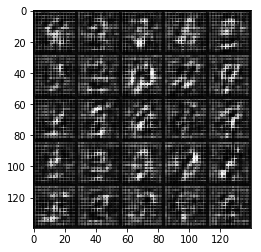

Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 2.2285
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.9098
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 2.2251
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 1.7772
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 2.5749
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.4049
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 2.1005


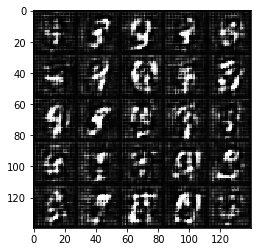

Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.7333
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.7023
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.4962
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.4327
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.9414
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 1.8034
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.4399
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.6971


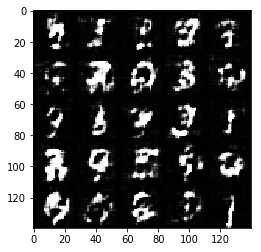

Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 2.5557
Epoch 1/2... Discriminator Loss: 0.8449... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.7144
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.9950
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 1.1514
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.7215


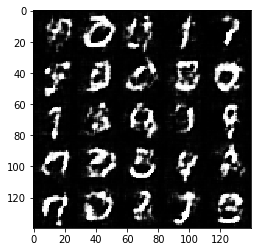

Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 1.3754
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.2382
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 1.1413
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 2.0582
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.0782


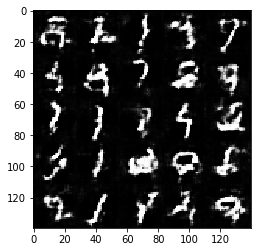

Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.0937
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.3334
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.5609


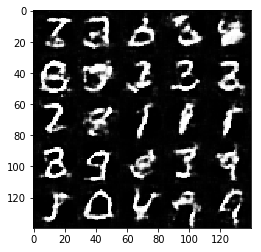

Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 1.4155
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.7690
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 1.2196
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 1.0112


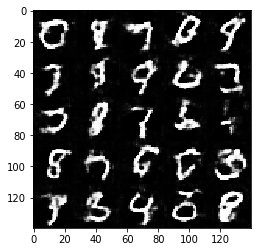

Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.0648
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.4322
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.4913
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.2041


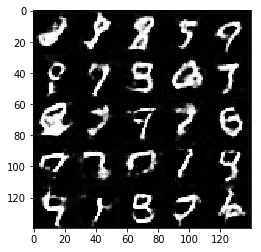

Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 1.7486
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 1.7689
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.1465
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.0328
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.4980
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.1135


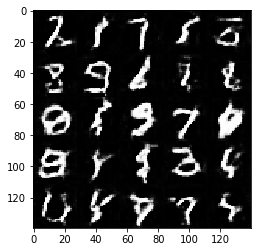

Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 0.9510
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 1.5837
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.4921
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.5694
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.2573


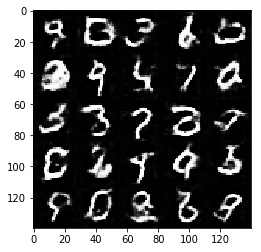

Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 1.0305... Generator Loss: 0.9126
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.9987
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.5649
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 1.2711
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.4754


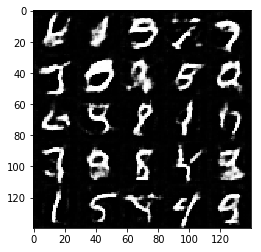

Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 1.3070
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.4010
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.3983
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 2.2854
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.1637


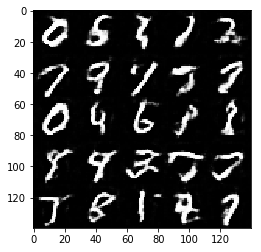

Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.4464
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 0.9248
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.8742


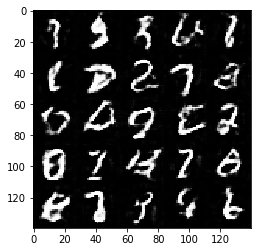

Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.4568
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.1703
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 1.6083
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 2.2326
Epoch 2/2... Discriminator Loss: 2.2774... Generator Loss: 3.4153
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 0.8746


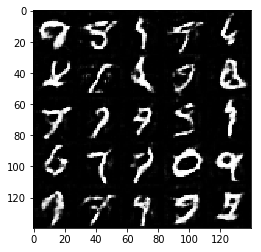

Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 0.8659
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.0103
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.4199
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.5673
Epoch 2/2... Discriminator Loss: 0.9929... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.5565


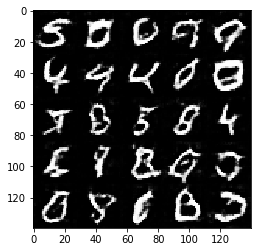

Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 2.0631
Epoch 2/2... Discriminator Loss: 1.6784... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.3381
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.8666


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.